<a href="https://colab.research.google.com/github/SusannaPinotti/GPT-2_JOKES_GENERATION/blob/main/Compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import nltk 
import re

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/jokes_project/Generated_dataset_3.csv")
data.drop(['Unnamed: 0'], inplace = True, axis = 1)


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
import string


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
data['generated_text'] = data['generated_text'].map(lambda x: x.lower())
data['generated_text'] = data['generated_text'].map(lambda x: re.sub('[0-9]', '', x))


In [ ]:
from IPython.core.displayhook import tokenize
from traitlets.traitlets import default
stops = stopwords.words('english')
stops.extend(['.', '!', "'", ",", "?", "\\", "/", "'ve", "'s", "'d", '``', "*",
              ":", ";", "n't", "...","'ll","'m", "'t", "'re","[", "]", '"', "(", ")",
              'one', "can't","got", "ca n't", "get", 'ca', "''", '......', 
              'problem', 'difference', 'people', 'president', 'friend', 'boss'])

def clean(text, stop): 
    tokens = word_tokenize(text)
    out = [t for t in tokens if t not in stop]
    return ' '.join(lemmatizer.lemmatize(token) for token in out)

c = []
for jk in data['generated_text']:
    jk = clean(jk, stops)
    c.append(jk)

clean_data = pd.DataFrame(data = c, )
clean_data.head()

,0
0,like grandfather old habit sure said right rea...
1,watch porno backwards even .... fucking close ...
2,like watch movie way view always getting tired...
3,say take lot time come new idea think truth ev...
4,like wow great idea think agree actually groun...


In [ ]:
%%capture
!pip install wordcloud
from wordcloud import WordCloud

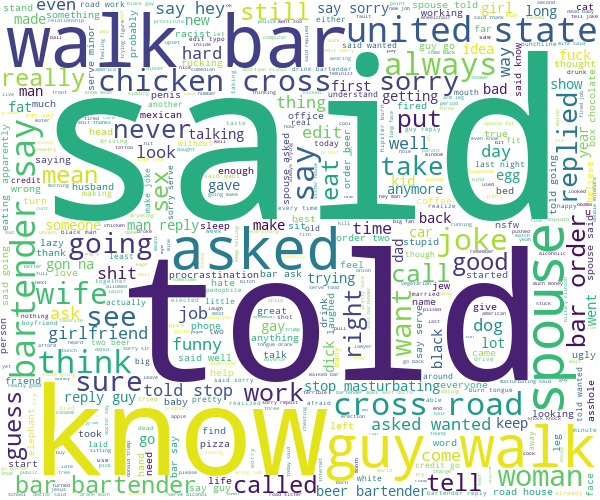

In [ ]:
full_text = " ".join(c)
cloud = WordCloud(width = 600, height = 500, background_color= 'white', max_words = 1000, 
                      contour_width= 10, contour_color= "steelblue")
cloud.generate(full_text)
cloud.to_image()


In [ ]:
cloud.to_file('/content/drive/MyDrive/jokes_project/images/word_cloud_GEN_DATASET.png')

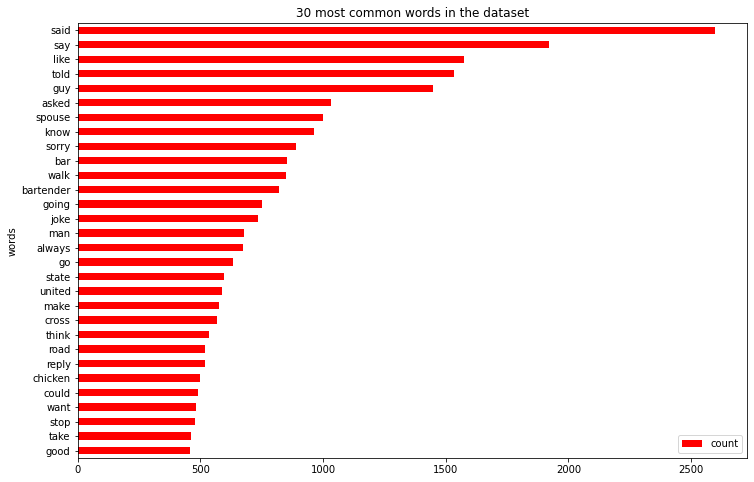

<Figure size 432x288 with 0 Axes>

In [ ]:
from collections import Counter 
cnt = Counter()

for w in full_text.split(sep = " "): 
    cnt[w] += 1 

#cnt.most_common(25)

#freq table 
word_freq = pd.DataFrame(cnt.most_common(30), columns = ['words', 'count'])
word_freq.head(30)

#plot 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))

word_freq.sort_values(by='count').plot.barh(x = 'words', 
                                            y= 'count', 
                                            ax = ax, 
                                            color = 'red')
ax.set_title('30 most common words in the dataset')
plt.show()
plt.savefig("/content/drive/MyDrive/jokes_project/images/frequencies_GEN_DATASET.png")

In [ ]:
import gensim 
from gensim.utils import simple_preprocess 

def sent_to_words(sentences): 
    for sentence in sentences: 
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))

data_words = list(sent_to_words(c))

In [ ]:
import gensim.corpora as corpora 

#dict
id2word = corpora.Dictionary(data_words)

#corpus
texts = data_words

#tdf
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[5])

[(3, 1), (4, 1), (47, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1)]


In [ ]:
from pprint import pprint 

In [ ]:
import warnings  
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')  
warnings.filterwarnings(action='ignore',category=DeprecationWarning,module='gensim')

In [ ]:
#LDA model training 

num_topics = 4
lda_model = gensim.models.LdaMulticore(corpus = corpus, 
                                       id2word = id2word, 
                                       num_topics = num_topics,
                                       passes = 3,  
                                       iterations = 500,
                                       per_word_topics = True, 
                                       )

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"say" + 0.017*"know" + 0.013*"egg" + 0.012*"always" + 0.011*"like" + '
  '0.010*"woman" + 0.010*"edit" + 0.009*"think" + 0.009*"go" + 0.009*"spouse"'),
 (1,
  '0.034*"guy" + 0.033*"say" + 0.030*"chicken" + 0.028*"sorry" + 0.022*"bar" + '
  '0.022*"man" + 0.021*"walk" + 0.020*"cross" + 0.020*"bartender" + '
  '0.019*"road"'),
 (2,
  '0.032*"said" + 0.022*"told" + 0.018*"like" + 0.015*"asked" + 0.015*"onion" '
  '+ 0.014*"joke" + 0.010*"going" + 0.009*"work" + 0.009*"wanted" + '
  '0.009*"know"'),
 (3,
  '0.039*"said" + 0.019*"told" + 0.012*"asked" + 0.011*"like" + 0.011*"cross" '
  '+ 0.010*"house" + 0.010*"road" + 0.010*"go" + 0.008*"always" + '
  '0.008*"going"')]


In [ ]:
%%capture
!pip install pyldavis

In [ ]:
import os
import pyLDAvis.gensim_models 
import pickle
import pyLDAvis
pyLDAvis.enable_notebook()

filepath = os.path.join('/content/drive/MyDrive/jokes_project/topic_mod_result_ONGENERATED'+str(num_topics))

if 1 == 1: 
    ldavis_prep = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(filepath, 'wb') as f: 
        pickle.dump(ldavis_prep, f)

with open(filepath, 'rb') as f: 
    ldavis_prep = pickle.load(f)

pyLDAvis.save_html(ldavis_prep, '/content/drive/MyDrive/jokes_project/topic_mod_result_ONGENERATED'+str(num_topics)+'.html')

ldavis_prep

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.117657 -0.014417       1        1  28.810638
3      0.071691 -0.101515       2        1  24.366375
1     -0.230465 -0.015491       3        1  23.816009
0      0.041118  0.131422       4        1  23.006978, topic_info=         Term         Freq        Total Category  logprob  loglift
1619  chicken   711.000000   711.000000  Default  30.0000  30.0000
7        said  1912.000000  1912.000000  Default  29.0000  29.0000
115       guy   998.000000   998.000000  Default  28.0000  28.0000
38        say  1359.000000  1359.000000  Default  27.0000  27.0000
1075      bar   522.000000   522.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
39       take   119.666503   479.606752   Topic4  -5.2493   0.0811
464      hard   108.354897   328.795530   Topic4  -5.3486   0.3593
363      mean   105.008628   292.368421   Topic4  -5.3799   0.4454
297       man   119.963152   646.724959   Topic4  -5.2468  -0.2154
100      make   113.577427   552.465223   Topic4  -5.3015  -0.1125

[318 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2701      1  0.020385  abortion
2701      2  0.020385  abortion
2701      3  0.061156  abortion
2701      4  0.896957  abortion
1004      1  0.971743  accident
...     ...       ...       ...
180       4  0.108993     would
841       3  0.968533       www
1478      1  0.976705   younger
1623      2  0.963295       zoo
1623      4  0.016900       zoo

[612 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
analyzer = SentimentIntensityAnalyzer()
clean_data['polarity'] = clean_data[0].apply(lambda x: analyzer.polarity_scores(x))
clean_data.head()

,0,polarity
0,people like grandfather old habits sure said r...,"{'neg': 0.0, 'neu': 0.467, 'pos': 0.533, 'comp..."
1,people watch porno backwards even .... fucking...,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp..."
2,people like watch movies way view always getti...,"{'neg': 0.177, 'neu': 0.671, 'pos': 0.152, 'co..."
3,people say takes lot time come new ideas think...,"{'neg': 0.0, 'neu': 0.85, 'pos': 0.15, 'compou..."
4,people like wow great idea think agree actuall...,"{'neg': 0.0, 'neu': 0.317, 'pos': 0.683, 'comp..."


In [ ]:
clean_data_1 = pd.concat([clean_data['polarity'].apply(pd.Series), clean_data.rename(columns={'0':'Joke'})], axis = 1)

In [ ]:
clean_data_1.head(3)

,neg,neu,pos,compound,0,polarity
0,0.000,0.467,0.533,0.7902,people like grandfather old habits sure said r...,"{'neg': 0.0, 'neu': 0.467, 'pos': 0.533, 'comp..."
1,0.000,0.893,0.107,0.1440,people watch porno backwards even .... fucking...,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp..."
2,0.177,0.671,0.152,-0.1027,people like watch movies way view always getti...,"{'neg': 0.177, 'neu': 0.671, 'pos': 0.152, 'co..."


In [ ]:
clean_data_1['sentiment'] = clean_data_1['compound'].apply(lambda x: 'positive' if x>0 else 'neutral' if x ==0 else 'negative')

In [ ]:
clean_data_1.head()

,neg,neu,pos,compound,0,polarity,sentiment
0,0.000,0.467,0.533,0.7902,people like grandfather old habits sure said r...,"{'neg': 0.0, 'neu': 0.467, 'pos': 0.533, 'comp...",positive
1,0.000,0.893,0.107,0.1440,people watch porno backwards even .... fucking...,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...",positive
2,0.177,0.671,0.152,-0.1027,people like watch movies way view always getti...,"{'neg': 0.177, 'neu': 0.671, 'pos': 0.152, 'co...",negative
3,0.000,0.850,0.150,0.3182,people say takes lot time come new ideas think...,"{'neg': 0.0, 'neu': 0.85, 'pos': 0.15, 'compou...",positive
4,0.000,0.317,0.683,0.9169,people like wow great idea think agree actuall...,"{'neg': 0.0, 'neu': 0.317, 'pos': 0.683, 'comp...",positive


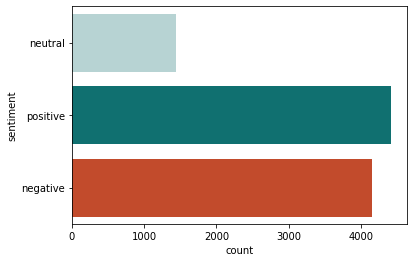

In [ ]:
import seaborn as sns
sns.countplot(y = 'sentiment', 
              order = ['neutral', 'positive', 'negative'], 
              data = clean_data_1, 
              palette = ['#b2d8d8',"#008080", '#db3d13'])